# Movie reviews

This notebook takes you though a complete iteration of Machine Learning Assignment 1 - Movie reviews. The assignment details (including links to download the data) can be found [here](https://docs.google.com/document/d/1WGYw99e5q6j5V0Zrf2HveagU6URt_kVvdR8B9HYQ99E/edit?usp=sharing). 

In [91]:
# all imports and magic commands
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from my_measures import BinaryClassificationPerformance
from sklearn.feature_extraction.text import HashingVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from scipy.sparse import csr_matrix, hstack
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
%matplotlib inline

### IMPORTANT!!! Make sure you are using `BinaryClassificationPerformance` v1.02

In [92]:
help(BinaryClassificationPerformance)

Help on class BinaryClassificationPerformance in module my_measures:

class BinaryClassificationPerformance(builtins.object)
 |  BinaryClassificationPerformance(predictions, labels, desc, probabilities=None)
 |  
 |  Performance measures to evaluate the fit of a binary classification model, v1.02
 |  
 |  Methods defined here:
 |  
 |  __init__(self, predictions, labels, desc, probabilities=None)
 |      Initialize attributes: predictions-vector of predicted values for Y, labels-vector of labels for Y
 |  
 |  compute_measures(self)
 |      Compute performance measures defined by Flach p. 57
 |  
 |  img_indices(self)
 |      Get the indices of true and false positives to be able to locate the corresponding images in a list of image names
 |  
 |  ----------------------------------------------------------------------
 |  Data descriptors defined here:
 |  
 |  __dict__
 |      dictionary for instance variables (if defined)
 |  
 |  __weakref__
 |      list of weak references to the obj

# Function for feature building and extraction on natural language data

In [93]:
# function that takes raw data and completes all preprocessing required before model fits
def process_raw_data(fn, my_random_seed, test=False):
    # read and summarize data
    movie_data = pd.read_csv(fn, sep='\t')
    print("movie_data is:", type(movie_data))
    print("movie_data has", movie_data.shape[0], "rows and", movie_data.shape[1], "columns", "\n")
    print("the data types for each of the columns in movie_data:")
    print(movie_data.dtypes, "\n")
    print("the first 10 rows in movie_data:")
    print(movie_data.head(5))
    if (not test):
        print("The rate of 'good' movie reviews in the dataset: ")
        print(movie_data['sentiment'].mean())

    # vectorize Bag of Words from review text; as sparse matrix
    if (not test): # fit_transform()
        hv = HashingVectorizer(n_features=2 ** 17, alternate_sign=False)
        X_hv = hv.fit_transform(movie_data.review)
        fitted_transformations.append(hv)
        print("Shape of HashingVectorizer X:")
        print(X_hv.shape)
    else: # transform() 
        X_hv = fitted_transformations[0].transform(movie_data.review)
        print("Shape of HashingVectorizer X:")
        print(X_hv.shape)
    
    # http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfTransformer.html
    if (not test):
        transformer = TfidfTransformer()
        X_tfidf = transformer.fit_transform(X_hv)
        fitted_transformations.append(transformer)
    else:
        X_tfidf = fitted_transformations[1].transform(X_hv)
    
    # create additional quantitative features
    # features from Amazon.csv to add to feature set
    movie_data['word_count'] = movie_data['review'].str.split(' ').str.len()
    movie_data['punc_count'] = movie_data['review'].str.count("\.")

    X_quant_features = movie_data[["word_count", "punc_count"]]
    print("Look at a few rows of the new quantitative features: ")
    print(X_quant_features.head(10))
    
    # Combine all quantitative features into a single sparse matrix
    X_quant_features_csr = csr_matrix(X_quant_features)
    X_combined = hstack([X_tfidf, X_quant_features_csr])
    X_matrix = csr_matrix(X_combined) # convert to sparse matrix
    print("Size of combined bag of words and new quantitative variables matrix:")
    print(X_matrix.shape)
    
    # Create `X`, scaled matrix of features
    # feature scaling
    if (not test):
        sc = StandardScaler(with_mean=False)
        X = sc.fit_transform(X_matrix)
        fitted_transformations.append(sc)
        print(X.shape)
        y = movie_data['sentiment']
    else:
        X = fitted_transformations[2].transform(X_matrix)
        print(X.shape)
    
    # Create Training and Test Sets
    # enter an integer for the random_state parameter; any integer will work
    if (test):
        X_submission_test = X
        print("Shape of X_test for submission:")
        print(X_submission_test.shape)
        print('SUCCESS!')
        return(movie_data, X_submission_test)
    else: 
        X_train, X_test, y_train, y_test, X_raw_train, X_raw_test = train_test_split(X, y, movie_data, test_size=0.2, random_state=my_random_seed)
        print("Shape of X_train and X_test:")
        print(X_train.shape)
        print(X_test.shape)
        print("Shape of y_train and y_test:")
        print(y_train.shape)
        print(y_test.shape)
        print("Shape of X_raw_train and X_raw_test:")
        print(X_raw_train.shape)
        print(X_raw_test.shape)
        print('SUCCESS!')
        return(X_train, X_test, y_train, y_test, X_raw_train, X_raw_test)

# Create training and test sets from function

In [94]:
# create an empty list to store any use of fit_transform() to transform() later
# it is a global list to store model and feature extraction fits
fitted_transformations = []

# CHANGE FILE PATH and my_random_seed number (any integer other than 74 will do): 
X_train, X_test, y_train, y_test, X_raw_train, X_raw_test = process_raw_data(fn='moviereviews_train.tsv', my_random_seed=5)

print("Number of fits stored in `fitted_transformations` list: ")
print(len(fitted_transformations))

movie_data is: <class 'pandas.core.frame.DataFrame'>
movie_data has 25000 rows and 3 columns 

the data types for each of the columns in movie_data:
id           object
sentiment     int64
review       object
dtype: object 

the first 10 rows in movie_data:
       id  sentiment                                             review
0  5814_8          1  With all this stuff going down at the moment w...
1  2381_9          1  \The Classic War of the Worlds\" by Timothy Hi...
2  7759_3          0  The film starts with a manager (Nicholas Bell)...
3  3630_4          0  It must be assumed that those who praised this...
4  9495_8          1  Superbly trashy and wondrously unpretentious 8...
The rate of 'good' movie reviews in the dataset: 
0.5
Shape of HashingVectorizer X:
(25000, 131072)
Look at a few rows of the new quantitative features: 
   word_count  punc_count
0         433          20
1         158          16
2         378          20
3         379           8
4         367           9


# Fit (and tune) Various Models

### MODEL: ordinary least squares

In [95]:
from sklearn import linear_model
ols = linear_model.SGDClassifier(loss="squared_loss")
ols.fit(X_train, y_train)

ols_performance_train = BinaryClassificationPerformance(ols.predict(X_train), y_train, 'ols_train')
ols_performance_train.compute_measures()
print(ols_performance_train.performance_measures)

{'Pos': 9961, 'Neg': 10039, 'TP': 4388, 'TN': 5606, 'FP': 4433, 'FN': 5573, 'Accuracy': 0.4997, 'Precision': 0.4974492687903866, 'Recall': 0.44051802027908843, 'desc': 'ols_train'}


### MODEL: SVM, linear

{'Pos': 9961, 'Neg': 10039, 'TP': 9961, 'TN': 10039, 'FP': 0, 'FN': 0, 'Accuracy': 1.0, 'Precision': 1.0, 'Recall': 1.0, 'desc': 'svm_train'}
{'Pos': 9961, 'Neg': 10039, 'TP': 9961, 'TN': 10039, 'FP': 0, 'FN': 0, 'Accuracy': 1.0, 'Precision': 1.0, 'Recall': 1.0, 'desc': 'default'}
{'Pos': 9961, 'Neg': 10039, 'TP': 8355, 'TN': 9866, 'FP': 173, 'FN': 1606, 'Accuracy': 0.91105, 'Precision': 0.9797138836772983, 'Recall': 0.8387712077100693, 'desc': 'c1'}
{'Pos': 9961, 'Neg': 10039, 'TP': 8355, 'TN': 9866, 'FP': 173, 'FN': 1606, 'Accuracy': 0.91105, 'Precision': 0.9797138836772983, 'Recall': 0.8387712077100693, 'desc': 'c2'}
{'Pos': 9961, 'Neg': 10039, 'TP': 8810, 'TN': 9813, 'FP': 226, 'FN': 1151, 'Accuracy': 0.93115, 'Precision': 0.9749889331562638, 'Recall': 0.8844493524746512, 'desc': 'c3'}
{'Pos': 9961, 'Neg': 10039, 'TP': 9903, 'TN': 9996, 'FP': 43, 'FN': 58, 'Accuracy': 0.99495, 'Precision': 0.9956766539312286, 'Recall': 0.9941772914366027, 'desc': 'c4'}


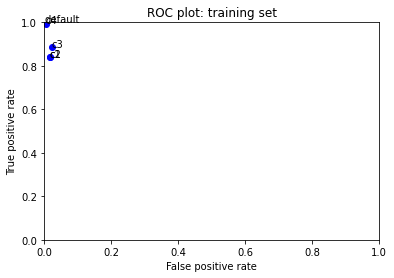

In [96]:
from sklearn import linear_model
svm = linear_model.SGDClassifier()
svm.fit(X_train, y_train)

svm_performance_train = BinaryClassificationPerformance(svm.predict(X_train), y_train, 'svm_train')
svm_performance_train.compute_measures()
print(svm_performance_train.performance_measures)

from sklearn import svm

svm_linear = svm.LinearSVC(loss='hinge')
svm_linear.fit(X_train, y_train)

svm_linear_c1 = svm.LinearSVC(loss='hinge', C=.000000001)
svm_linear_c1.fit(X_train, y_train)

svm_linear_c2 = svm.LinearSVC(loss='hinge', C=.00000002)
svm_linear_c2.fit(X_train, y_train)

svm_linear_c3 = svm.LinearSVC(loss='hinge', C=0.000003)
svm_linear_c3.fit(X_train, y_train)

svm_linear_c4 = svm.LinearSVC(loss='hinge', C=0.00004)
svm_linear_c4.fit(X_train, y_train)

svm_linear_performance_train = BinaryClassificationPerformance(svm_linear.predict(X_train), y_train, 'default')
svm_linear_performance_train.compute_measures()
print(svm_linear_performance_train.performance_measures)

svm_linear_performance_train_c1 = BinaryClassificationPerformance(svm_linear_c1.predict(X_train), y_train, 'c1')
svm_linear_performance_train_c1.compute_measures()
print(svm_linear_performance_train_c1.performance_measures)

svm_linear_performance_train_c2 = BinaryClassificationPerformance(svm_linear_c2.predict(X_train), y_train, 'c2')
svm_linear_performance_train_c2.compute_measures()
print(svm_linear_performance_train_c2.performance_measures)

svm_linear_performance_train_c3 = BinaryClassificationPerformance(svm_linear_c3.predict(X_train), y_train, 'c3')
svm_linear_performance_train_c3.compute_measures()
print(svm_linear_performance_train_c3.performance_measures)

svm_linear_performance_train_c4 = BinaryClassificationPerformance(svm_linear_c4.predict(X_train), y_train, 'c4')
svm_linear_performance_train_c4.compute_measures()
print(svm_linear_performance_train_c4.performance_measures)

#graphs for C changes to svm models on training set data
graphs = [svm_linear_performance_train, svm_linear_performance_train_c1, svm_linear_performance_train_c2, svm_linear_performance_train_c3, svm_linear_performance_train_c4]

for graph in graphs:
    plt.plot(graph.performance_measures['FP'] / graph.performance_measures['Neg'], 
             graph.performance_measures['TP'] / graph.performance_measures['Pos'], 'bo')
    plt.text(graph.performance_measures['FP'] / graph.performance_measures['Neg'], 
             graph.performance_measures['TP'] / graph.performance_measures['Pos'], graph.desc)
plt.axis([0, 1, 0, 1])
plt.title('ROC plot: training set')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.show()

### MODEL: logistic regression

In [81]:
from sklearn import linear_model
lgs = linear_model.SGDClassifier(loss='log')
lgs.fit(X_train, y_train)

lgs_performance_train = BinaryClassificationPerformance(lgs.predict(X_train), y_train, 'lgs_train')
lgs_performance_train.compute_measures()
print(lgs_performance_train.performance_measures)

{'Pos': 9961, 'Neg': 10039, 'TP': 9961, 'TN': 10039, 'FP': 0, 'FN': 0, 'Accuracy': 1.0, 'Precision': 1.0, 'Recall': 1.0, 'desc': 'lgs_train'}


### MODEL: Naive Bayes

In [82]:
from sklearn.naive_bayes import MultinomialNB
nbs = MultinomialNB()
nbs.fit(X_train, y_train)

nbs_performance_train = BinaryClassificationPerformance(nbs.predict(X_train), y_train, 'nbs_train')
nbs_performance_train.compute_measures()
print(nbs_performance_train.performance_measures)

{'Pos': 9961, 'Neg': 10039, 'TP': 9548, 'TN': 9870, 'FP': 169, 'FN': 413, 'Accuracy': 0.9709, 'Precision': 0.982607800761552, 'Recall': 0.9585382993675334, 'desc': 'nbs_train'}


### MODEL: Perceptron

In [83]:
from sklearn import linear_model
prc = linear_model.SGDClassifier(loss='perceptron')
prc.fit(X_train, y_train)

prc_performance_train = BinaryClassificationPerformance(prc.predict(X_train), y_train, 'prc_train')
prc_performance_train.compute_measures()
print(prc_performance_train.performance_measures)

{'Pos': 9961, 'Neg': 10039, 'TP': 9961, 'TN': 10039, 'FP': 0, 'FN': 0, 'Accuracy': 1.0, 'Precision': 1.0, 'Recall': 1.0, 'desc': 'prc_train'}


### MODEL: Ridge Regression Classifier

In [84]:
from sklearn import linear_model
rdg = linear_model.RidgeClassifier()
rdg.fit(X_train, y_train)

rdg_performance_train = BinaryClassificationPerformance(rdg.predict(X_train), y_train, 'rdg_train')
rdg_performance_train.compute_measures()
print(rdg_performance_train.performance_measures)

{'Pos': 9961, 'Neg': 10039, 'TP': 9961, 'TN': 10039, 'FP': 0, 'FN': 0, 'Accuracy': 1.0, 'Precision': 1.0, 'Recall': 1.0, 'desc': 'rdg_train'}


### MODEL: Random Forest Classifier

In [85]:
from sklearn.ensemble import RandomForestClassifier
rdf = RandomForestClassifier(max_depth=2, random_state=0)
rdf.fit(X_train, y_train)

rdf_performance_train = BinaryClassificationPerformance(rdf.predict(X_train), y_train, 'rdf_train')
rdf_performance_train.compute_measures()
print(rdf_performance_train.performance_measures)

{'Pos': 9961, 'Neg': 10039, 'TP': 7005, 'TN': 8046, 'FP': 1993, 'FN': 2956, 'Accuracy': 0.75255, 'Precision': 0.7785063347410536, 'Recall': 0.7032426463206506, 'desc': 'rdf_train'}


### ROC plot to compare performance of various models and fits

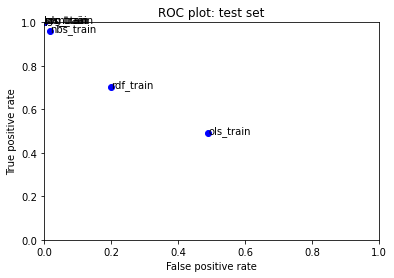

In [86]:
fits = [ols_performance_train, svm_performance_train, lgs_performance_train, nbs_performance_train, prc_performance_train, rdg_performance_train, rdf_performance_train]

for fit in fits:
    plt.plot(fit.performance_measures['FP'] / fit.performance_measures['Neg'], 
             fit.performance_measures['TP'] / fit.performance_measures['Pos'], 'bo')
    plt.text(fit.performance_measures['FP'] / fit.performance_measures['Neg'], 
             fit.performance_measures['TP'] / fit.performance_measures['Pos'], fit.desc)
plt.axis([0, 1, 0, 1])
plt.title('ROC plot: test set')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.show()

### looking at reviews based on their classification

Let's say we decide that Ordinary Least Squares (OLS) Regression is the best model for generalization. Let's take a look at some of the reviews and try to make a (subjective) determination of whether it's generalizing well. 

In [87]:
ols_predictions = ols.predict(X_train)

### let's look at some false positives:

In [88]:
# false positives

print("Examples of false positives:")

import random, time

for i in range(0, len(ols_predictions)):
    if (ols_predictions[i] == 1):
        if (X_raw_train.iloc[i]['sentiment'] == 0):
            if (random.uniform(0, 1) < 0.05): # to print only 5% of the false positives
                print(i)
                print(X_raw_train.iloc[i]['review'])
                print('* * * * * * * * * ')


Examples of false positives:
9
\Extreme Makeover: Home Edition\" is yet another 'feel-goody', so-called 'heart warming', and out-for-ratings show that ABC has had the time to put together.<br /><br />I understand the troubles that these families go through. For that, I am sorry. But wouldn't you think that putting four wide-screen plasma televisions, three flat-screen desktop computers, an inground pool taking up half of a backyard, and closets full of expensive designer clothing is a BIT too excessive for ANY family? Sure, these families have been through a lot. Sure, they deserve nicer things that what they had previously had.<br /><br />But honestly, the things that Ty Pennington and his crew put into these houses are enough to suit an entire neighborhood.<br /><br />Another thing that really irks me about this show is how Ty and his crew always have something good to say about every little thing that relates to the family, or the family's condition. Telling a wheelchair-bound perso

3916
I saw this movie last year in Media class and I have to say I really hated it. I was in year 10 (and aged 15) so that may have has something to do with it. But for English this year, year 11, we had to read Animal Farm, also by George Orwell. Aside from the fact that the book is based on the Revolution, my opinion is that it is a terrible book, and I also hated it.<br /><br />But 1984, I think it was the most disturbing movie I have ever seen, and I think that George Orwell is one of the most deranged people ever to live on this planet. I'm sorry to everyone who loved his work, but I unfortunately did not. The themes in the movie were well portrayed, but the way the whole movie was set and the events that took place within it were not to my standards. This is only my opinion, and I'm sure many many other people thoroughly enjoyed this film.
* * * * * * * * * 
3960
The most embarrassing moment in this film is when Brady Corbet says 'You've blossomed', near the end the film. I pract

7354
Should have been titled 'Balderdash!' Little in the film is true except the name of the island and the fact submarines were involved. Little more than training film quality with poor camera work, muddy stock footage and perhaps the low point of stereotyping 'Japs' with laughing Japanese infantry, laughing Japanese fighter pilots and one-dimensional square-jawed Americans dying left and right. Sixty years later it is unintentionally funny as an odd artifact and as an opportunity to see what is possible when the war fever is upon you. The plot and the dialogue remind me of playing guns on a summer's afternoon in my childhood, peering through the neighbor's hedge to gain a fatal advantage on my best friend Steve and my little brother. In actual fact, the Makin Island raid was a near total failure with Carlson and his men wandering around in the dark exchanging gunfire with shadows until finally, thirsty and completely disoriented, looking for someone to surrender to, before they happ

11070
Vampire cyborgs rule the world and use the blood of humans as fuel, however there is going to be a shift of power thanks to a renegade android (Kris Kristofferson) and a warrior woman (Kathly Long) as they face off against Lance Henriksen and Gary Daniels (Who play the cyborgs in this ridiculous movie) Of all the questions left unanswered by this dreadful movie, the most poignant is Who's idea was it to cast country singer Kris Kristofferson as a cyborg warrior who is able to give as good as he gets. No, don't get me wrong I could see Kristofferson as a vigilante or something but not as a cyborg. Strangely one suspects that this was written for Dolph Lundgren, however Lundgren must have had the wisdom to not do it. However despite the disastrous casting, Kristofferson is easily the most enjoyable thing about the movie. He gives a performance far more human then the inexpressive Kathy Long. (And Kristofferson is playing a robot) despite the miscasting, Kristofferson provides the f

12130
end of the world looks like a good movie on the box cover but be warned its bad.being a big fan of mega star actor Christopher lee i was fooled. like tentacles(77)a good cast does not mean it'll be a good film.the beginning looks promising then it turns to tedium,many parts of the movie are too dark to see whats going on.the rest of the cast is shown briefly like;Lew ayres,dean Jagger,and MacDonald Carey as a security guard.i would expect better from Charles band who made good fun movies like the re-animater and dolls.i heard Christopher lee was tricked into making this film.he was told his co stars were going to be Jose ferrer,john carridine,and dean Jagger.well dean Jagger is there but the other two never made it(lucky them)if you make a movie about the end of the world use a bigger budget and better storyline.dean Jagger went on to do two good movies afterwards;alligator(80)and game of death(79) sue Lyon(Lolita)is also in the movie minus her lollipop.if you are a glutton for p

14455
Lame, cliched superhero action movie drivel. I had high hopes for this movie, and the genre of HK buddy cop actioneers is one that i don't despise, but very rarely do i see a storyline as trite and ludicrous as this one was. This would have been forgivable, as it always is in these kinds of movies, when the action compensates, unfortunately, it did not. The action does carry the trademark surreality and over the top nature of HK action, but it's not very involving, obscenely gory, and in fact often completely incoherent (perhaps this is due to re-editing for american release, it does show signs in many places of patchwork). I was very disappointed.
* * * * * * * * * 
14662
Although I had some hopes for this film, particularly since I enjoy the acting of Jason Segel (Freaks & Geeks, Undeclared) so much, I must say it was one of the worst films I've seen in recent memory (Loser and Dr T and the Women are also on that list).<br /><br />Yes, there were a couple of laugh out loud mome

15823
Seriously, what is THIS? Hooper has made such classic films like Texas Chainsaw Massacre, then he made this god awful film, what happened? did he dip into the crack a little too much? This film is about some dude named Sam who has the ability to set things on fire,(Firestarter, anyone?) the acting was godawful, the plot was rubbish, and the special effects were extremely rubbish, they looked like something from the 70's. Van Damme should be pleased that Derailed is no longer the worst film ever, and what was with the ending? he started glowing blue, turned into a glowing blue blob, sucked out his girlfriends fire, and the film ended. WHAT WAS THAT? HUH? when the film ended I hoped the DVD would Spontaniously Combust to save me from my pain.<br /><br />STAY AWAY FROM THIS FILM.<br /><br />DON'T THINK, OBEY, you'll thank me later.
* * * * * * * * * 
15832
the writing of the journalists and the required over eager reckless press officer and sobbing grandma was ham-fisted and cliché 

It must be assumed that those who praised this film (\the greatest filmed opera ever,\" didn't I read somewhere?) either don't care for opera, don't care for Wagner, or don't care about anything except their desire to appear Cultured. Either as a representation of Wagner's swan-song, or as a movie, this strikes me as an unmitigated disaster, with a leaden reading of the score matched to a tricksy, lugubrious realisation of the text.<br /><br />It's questionable that people with ideas as to what an opera (or, for that matter, a play, especially one by Shakespeare) is \"about\" should be allowed anywhere near a theatre or film studio; Syberberg, very fashionably, but without the smallest justification from Wagner's text, decided that Parsifal is \"about\" bisexual integration, so that the title character, in the latter stages, transmutes into a kind of beatnik babe, though one who continues to sing high tenor -- few if any of the actors in the film are the singers, and we get a double do

18783
I've seen some crappy movies in my life, but this one must be among the very worst. Definately bottom 100 material (imo, that is).<br /><br />We follow two couples, the Dodds (Billy Bob Thornton as Lonnie Earl and Natasha Richardson as Darlene) and the Kirkendalls (Patrick Swayze as Roy and Charlize Theron as Candy) in one car on a roadtrip to Reno.<br /><br />Apparently, Lonnie isn't too happy with his sex-life, so he cheats on his wife with Candy, who's despirately trying to have a baby. Roy, meanwhile, isn't too sure if his sperm is OK so he's getting it checked by a doctor.<br /><br />Now, I had read the back of the DVD, but my girlfriend didn't, and she blurted out after about 20 minutes: 'oh yeah, she's gonna end up pregnant but her husband can't have any baby's'. Spot on, as this movie is soooo predictable. As well as boring. And annoying. Meaningless. Offensive. Terrible.<br /><br />An example of how much this movie stinks. The two couples set out in their big car towards

---

# <span style="color:red">WARNING: Don't look at test set performance too much!</span>

---

The following cells show performance on your test set. Do not look at this too often! 

# Look at performance on the test set

### MODEL: ordinary least squares

In [89]:
ols_performance_test = BinaryClassificationPerformance(ols.predict(X_test), y_test, 'ols_test')
ols_performance_test.compute_measures()
print(ols_performance_test.performance_measures)

{'Pos': 2539, 'Neg': 2461, 'TP': 1281, 'TN': 1326, 'FP': 1135, 'FN': 1258, 'Accuracy': 0.5214, 'Precision': 0.5302152317880795, 'Recall': 0.5045293422607325, 'desc': 'ols_test'}


### MODEL: SVM, linear

{'Pos': 2539, 'Neg': 2461, 'TP': 2197, 'TN': 2077, 'FP': 384, 'FN': 342, 'Accuracy': 0.8548, 'Precision': 0.8512204571871368, 'Recall': 0.8653012997243009, 'desc': 'default'}
{'Pos': 2539, 'Neg': 2461, 'TP': 1825, 'TN': 2313, 'FP': 148, 'FN': 714, 'Accuracy': 0.8276, 'Precision': 0.9249873289406995, 'Recall': 0.7187869239858212, 'desc': 'c1'}
{'Pos': 2539, 'Neg': 2461, 'TP': 1825, 'TN': 2313, 'FP': 148, 'FN': 714, 'Accuracy': 0.8276, 'Precision': 0.9249873289406995, 'Recall': 0.7187869239858212, 'desc': 'c2'}
{'Pos': 2539, 'Neg': 2461, 'TP': 1987, 'TN': 2260, 'FP': 201, 'FN': 552, 'Accuracy': 0.8494, 'Precision': 0.9081352833638026, 'Recall': 0.7825915714848366, 'desc': 'c3'}
{'Pos': 2539, 'Neg': 2461, 'TP': 2247, 'TN': 2157, 'FP': 304, 'FN': 292, 'Accuracy': 0.8808, 'Precision': 0.8808310466483732, 'Recall': 0.8849940921622687, 'desc': 'c4'}


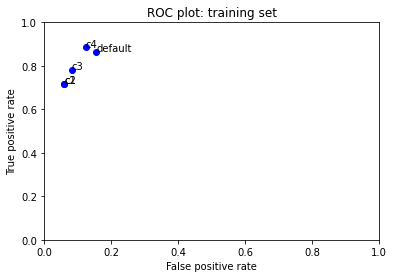

In [99]:
#svm_performance_test = BinaryClassificationPerformance(svm.predict(X_test), y_test, 'svm_test')
#svm_performance_test.compute_measures()
#print(svm_performance_test.performance_measures)

svm_linear_performance_test = BinaryClassificationPerformance(svm_linear.predict(X_test), y_test, 'default')
svm_linear_performance_test.compute_measures()
print(svm_linear_performance_test.performance_measures)

svm_linear_performance_test_c1 = BinaryClassificationPerformance(svm_linear_c1.predict(X_test), y_test, 'c1')
svm_linear_performance_test_c1.compute_measures()
print(svm_linear_performance_test_c1.performance_measures)

svm_linear_performance_test_c2 = BinaryClassificationPerformance(svm_linear_c2.predict(X_test), y_test, 'c2')
svm_linear_performance_test_c2.compute_measures()
print(svm_linear_performance_test_c2.performance_measures)

svm_linear_performance_test_c3 = BinaryClassificationPerformance(svm_linear_c3.predict(X_test), y_test, 'c3')
svm_linear_performance_test_c3.compute_measures()
print(svm_linear_performance_test_c3.performance_measures)

svm_linear_performance_test_c4 = BinaryClassificationPerformance(svm_linear_c4.predict(X_test), y_test, 'c4')
svm_linear_performance_test_c4.compute_measures()
print(svm_linear_performance_test_c4.performance_measures)

#graphs for C changes to svm models on training set data
graphs = [svm_linear_performance_test, svm_linear_performance_test_c1, svm_linear_performance_test_c2, svm_linear_performance_test_c3, svm_linear_performance_test_c4]

for graph in graphs:
    plt.plot(graph.performance_measures['FP'] / graph.performance_measures['Neg'], 
             graph.performance_measures['TP'] / graph.performance_measures['Pos'], 'bo')
    plt.text(graph.performance_measures['FP'] / graph.performance_measures['Neg'], 
             graph.performance_measures['TP'] / graph.performance_measures['Pos'], graph.desc)
plt.axis([0, 1, 0, 1])
plt.title('ROC plot: training set')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.show()

### MODEL: logistic regression

In [ ]:
lgs_performance_test = BinaryClassificationPerformance(lgs.predict(X_test), y_test, 'lgs_test')
lgs_performance_test.compute_measures()
print(lgs_performance_test.performance_measures)

### MODEL: Naive Bayes

In [ ]:
nbs_performance_test = BinaryClassificationPerformance(nbs.predict(X_test), y_test, 'nbs_test')
nbs_performance_test.compute_measures()
print(nbs_performance_test.performance_measures)

### MODEL: Perceptron

In [ ]:
prc_performance_test = BinaryClassificationPerformance(prc.predict(X_test), y_test, 'prc_test')
prc_performance_test.compute_measures()
print(prc_performance_test.performance_measures)

### MODEL: Ridge Regression Classifier

In [ ]:
rdg_performance_test = BinaryClassificationPerformance(rdg.predict(X_test), y_test, 'rdg_test')
rdg_performance_test.compute_measures()
print(rdg_performance_test.performance_measures)

### MODEL: Random Forest Classifier

In [ ]:
rdf_performance_test = BinaryClassificationPerformance(rdf.predict(X_test), y_test, 'rdf_test')
rdf_performance_test.compute_measures()
print(rdf_performance_test.performance_measures)

### ROC plot to compare performance of various models and fits

In [ ]:
fits = [ols_performance_test, svm_performance_test, lgs_performance_test, nbs_performance_test, prc_performance_test, rdg_performance_test, rdf_performance_test]

for fit in fits:
    plt.plot(fit.performance_measures['FP'] / fit.performance_measures['Neg'], 
             fit.performance_measures['TP'] / fit.performance_measures['Pos'], 'bo')
    plt.text(fit.performance_measures['FP'] / fit.performance_measures['Neg'], 
             fit.performance_measures['TP'] / fit.performance_measures['Pos'], fit.desc)
plt.axis([0, 1, 0, 1])
plt.title('ROC plot: test set')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.show()

In [ ]:
# read in test data for submission
# CHANGE FILE PATH and my_random_seed number (any integer other than 74 will do): 
raw_data, X_test_submission = process_raw_data(fn='/home/ec2-user/data/moviereviews_test.tsv', my_random_seed=5, test=True)
print("Number of rows in the submission test set (should be 25,000): ")

---

# <span style="color:red">SUBMISSION</span>

---

---

Choose a <span style="color:red">*single*</span> model for your submission. In this code, I am choosing the Ordinary Least Squares model fit, which is in the `ols` object. But you should choose the model that is performing the best for you! 

In [ ]:
# store the id from the raw data
my_submission = pd.DataFrame(raw_data["id"])
# concatenate predictions to the id
my_submission["prediction"] = ols.predict(X_test_submission)
# look at the proportion of positive predictions
print(my_submission['prediction'].mean())

In [ ]:
raw_data.head()

In [ ]:
my_submission.head()

In [ ]:
my_submission.shape

In [ ]:
# export submission file as pdf
# CHANGE FILE PATH: 
my_submission.to_csv('/home/ec2-user/data/moviereviews_submission.csv', index=False)

# Submit to Canvas: 1) the CSV file that was written in the previous cell and 2) the url to the repository (GitHub or other) that contains your code and documentation